# Beamforming (slow)

In this notebook, we locate the source of a synthetic wavefield recorded on an array of sensors using beamforming. The notebook follows three steps:

1. Geometry: define the geometry of sensors, source, and gridpoints to test
2. Recordings (synthetic): compute synthetic seismograms recorded on each sensor
3. Beamforming: compute cross-correlation beamformer output within a frequency band

For more background information, see the README.

## 1. Geometry

Text(0.5, 1.0, 'geometry of sensors, source, and grid')

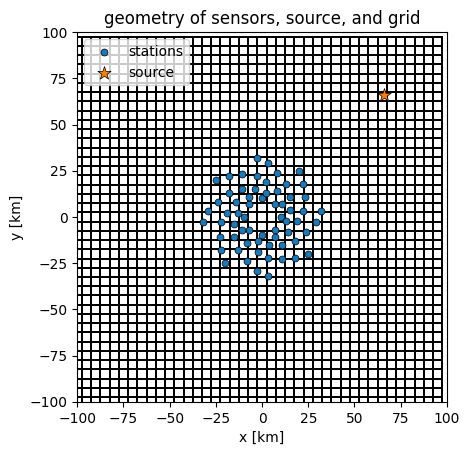

In [3]:
from itertools import product

import pylab as plt
import numpy as np
from math import sqrt, tan, exp

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return [x, y]
np.random.seed(42)

# geometry of the problem
n_sensors = 64
N_a = 8
N_m = int(n_sensors/N_a)
r_0 = 10
r_max = 400
v= np.pi/2.8
l_max = r_0*sqrt(1+(1/tan(v)**2)/(1/tan(v)))*(r_max/r_0-1)
# uniform random distribution in [-25, 25]
stations = np.array([[0,0]]*n_sensors)
counter = 0
for n in range(1,N_m+1):
    l_n = (n-1)*l_max/(n_sensors-1)
    theta =  tan(v)*np.log(1+((1/tan(v)*l_n)/(r_0*sqrt(1+(1/tan(v))**2))))
    r = r_0*exp(1/tan(v)*theta)
    for m in range(1,N_a+1): 
        theta_0 = (m-1)/N_a*2*np.pi
        step = pol2cart(r,theta+theta_0)
        stations[counter] = np.array(step)
        counter += 1
#stations = np.random.uniform(-25, 25, size=(n_sensors, 2))
source = np.array([66,66])

# generate grid points
grid_limit = 100
grid_spacing = 5
grid_coords = np.arange(-grid_limit, grid_limit, grid_spacing)
gridpoints = np.array(list(product(grid_coords, repeat=2)))

# generate empty grid cells for visulation
xx, yy = np.meshgrid(grid_coords, grid_coords, indexing="xy")
empty_cells = np.zeros_like(xx) * np.nan

# plotting
fig, ax = plt.subplots(1)
ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.01)
ax.scatter(*stations.T, marker=".", s=100, label="stations", ec='k', lw=0.5)
ax.scatter(*source, marker="*", s=100, label="source", ec='k', lw=0.5)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("geometry of sensors, source, and grid")

## 2. Recordings (synthetic)

In a field data application, replace `waveform_spectra` by the spectra of your recordings.

C:\Users\Wout\AppData\Local\Temp\ipykernel_25796\3937789784.py:22: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = np.fft.fft(ricker(len(times), sampling_rate))


Text(0.5, 1.0, '(synthetic) recordings on sensors')

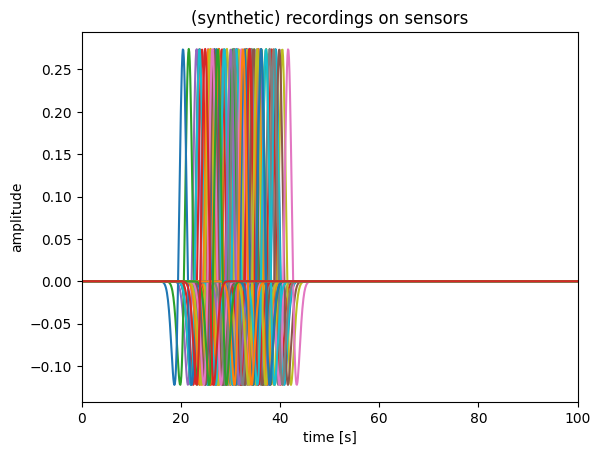

In [22]:
from scipy.signal import ricker

# define time
window_length = 100
sampling_rate = 10
times = np.arange(0, window_length + 1 / sampling_rate, 1 / sampling_rate)

# compute frequencies
freqs = np.fft.fftfreq(len(times), 1 / sampling_rate)
omega = 2 * np.pi * freqs

# define medium
# acoustic homogeneous half-space
medium_velocity = 3

# compute travel times
distances = np.linalg.norm(stations - source, axis=1)
traveltimes = distances / medium_velocity

# define source wavelet
wavelet = np.fft.fft(ricker(len(times), sampling_rate))

# compute waveforms for all stations for given source
# Green's functions are exp(-iωt)
# waveforms are only computed for plotting purposes.
# In a usual field data application, waveforms already exist
# and waveform_spectra need to be computed.
waveform_spectra = wavelet * np.exp(-1j * omega[None, :] * traveltimes[:, None])
waveforms = np.fft.fftshift(np.fft.ifft(waveform_spectra, axis=1).real)

# plotting
fig, ax = plt.subplots(1)
ax.plot(times, waveforms.T)
ax.set_xlim(0, window_length)
ax.set_xlabel("time [s]")
ax.set_ylabel("amplitude")
ax.set_title ("(synthetic) recordings on sensors")


## 3. Beamforming

Here, we compute beampowers using cross-correlation beamforming

$B(\mathbf{r_s}) = \sum_\omega \sum_j \sum_{k\neq j} K_{jk}(\omega) S_{kj}(\mathbf{r_s}, \omega)$,

with $B$ the beampower for potential source location $\mathbf{r_s}$, $j,k$ the sensors indices, $K$ the cross-spectral density matrix of recorded signals, and $S$ the cross-spectral density matrix of Green's functions (or replica vectors). For more details, see the README.

**Note on plane-wave beamforming**

The kind of beamforming here is Matched Field Processing, i.e., testing a spatial grid and not a slowness grid. For plane-wave beamforming, make three changes to this notebook:
1. Change the grid from spatial ($x, y$) to horizontal slownesses ($u_x, u_y$)
2. Adapt the computation of travel times to $t = u_x x_j + u_y y_j$, where $x_j, y_j$ is the position of sensor $j$ relative to a reference point.
3. Plot slowness grid instead of spatial view for beamforming result

In [23]:
# "PURE" PYTHON BEAMFORMER
# >> SLOW <<
# THIS IS ONLY FOR EDUCATIONAL PURPOSES, TRY TO AVOID USING THIS
# this version is quite explicit 
# and should be fairly straight-forward to understand
# makes no use of broadcasting or np.einsum

# Frequency band to use for beamform
fmin, fmax = 0.1, 1.0

# limit to this band
freq_idx = np.where((freqs > fmin) & (freqs < fmax))[0]
omega_lim = omega[freq_idx]
waveform_spectra_lim = waveform_spectra[:, freq_idx]

# cross-spectral density matrix of recordings
K = np.zeros([len(stations), len(stations), len(omega_lim)]).astype(
    complex
)
for i, spec_i in enumerate(waveform_spectra_lim):
    for j, spec_j in enumerate(waveform_spectra_lim):
        # skip diagonals, i.e., exclude auto-correlations
        if i == j:
            continue
        K[i, j] = spec_i * np.conj(spec_j)

beampowers = []
for gridpoint in gridpoints:
    # theoretical traveltimes from this gridpoint to all stations
    distances = np.linalg.norm(
       gridpoint - stations, axis=1
    )
    traveltimes = distances / medium_velocity

    # Green's functions for travel times
    # within selected frequency band
    # G = exp(-iωt)
    greens_functions = [np.exp(-1j * omega_lim * t) for t in traveltimes]

    # conventional beamformer
    # for more details, see e.g., Schippkus et al. 2022 or README
    # B = Σ_ω Σ_i Σ_j s^*_i(ω) K_ij(ω) s_j(ω)
    beam_spectra = []
    for i, spec_i in enumerate(greens_functions):
        for j, spec_j in enumerate(greens_functions):
            beam_spectrum = np.conj(spec_i) * K[i, j] * spec_j
            beam_spectra.append(beam_spectrum.real)
    beampower = np.sum(beam_spectra)
    beampowers.append(beampower)
beampowers = np.array(beampowers)


Text(0.5, 1.0, 'beamforming synthetics')

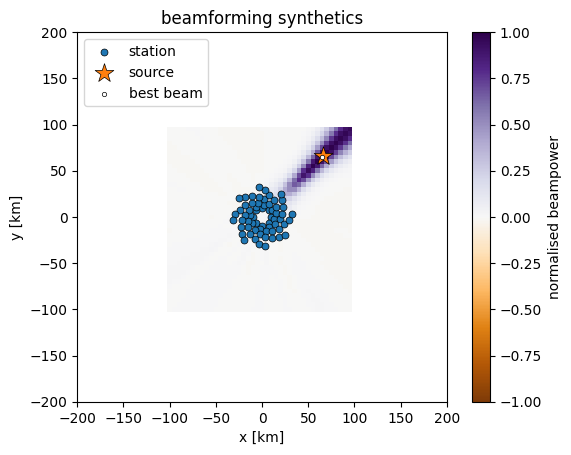

In [24]:
# plot beamforming result
fig, ax = plt.subplots(1)

bp = beampowers.reshape(len(grid_coords), len(grid_coords))
bp /= abs(bp).max()
pcm = ax.pcolormesh(xx, yy, bp.T, cmap="PuOr", vmin=-1, vmax=1)
ax.scatter(*stations.T, marker=".", s=100, label="station", ec='k', lw=0.5)
ax.scatter(*source, marker="*", s=200, label="source", ec='k', lw=0.5)
ax.scatter(
    *gridpoints[bp.argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
)
# ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.1, alpha=0.5)
plt.colorbar(pcm, label="normalised beampower")
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("beamforming synthetics")